# Modelling and Evaluation Notebook

## Objectives

*   Answer business requirement 2: 
    * The client is interested to tell whether a given cell contains pizza or not.


## Inputs

* inputs/carlosrunner/pizza-not-pizza/pizza_not_pizza/train
* inputs/carlosrunner/pizza-not-pizza/pizza_not_pizza/test
* inputs/carlosrunner/pizza-not-pizza/pizza_not_pizza/validation
* image shape embeddings.

## Outputs
* Images distribution plot in train, validation, and test set.
* Image augmentation.
* Class indices to change prediction inference in labels.
* Machine learning model creation and training.
* Save model.
* Learning curve plot for model performance.
* Model evaluation on pickle file.
* Prediction on the random image file.




## Additional Comments | Insights | Conclusions

---

# Import regular packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

---

# Set Working Directory

In [2]:
cwd= os.getcwd()

In [3]:
os.chdir('/workspaces/pizza-not-pizza')
print("You set a new current directory")

You set a new current directory


In [4]:
work_dir = os.getcwd()
work_dir

'/workspaces/pizza-not-pizza'

---

## Set input directories

In [5]:
my_data_dir = 'inputs/carlosrunner/pizza-not-pizza/pizza_not_pizza'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set output directory

In [6]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


## Set labels

In [7]:
labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
)

Project Labels: ['pizza', 'not_pizza']


## Set image shape

In [8]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

# Number of images in train, test and validation data

* train - pizza: 688 images
* train - not_pizza: 688 images
* validation - pizza: 98 images
* validation - not_pizza: 98 images
* test - pizza: 197 images
* test - not_pizza: 197 images




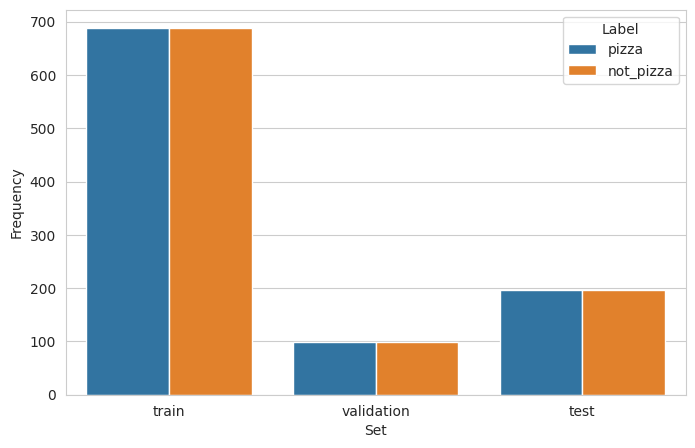

In [9]:
df_freq = pd.DataFrame([])
for folder in ['train', 'validation', 'test']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )

        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

---

# Image data augmentation

---

### ImageDataGenerator

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

* ### Initialize ImageDataGenerator

In [11]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

* ### Augment training image dataset

In [29]:
batch_size = 15  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 1376 images belonging to 2 classes.


{'not_pizza': 0, 'pizza': 1}

* ### Augment validation image dataset

In [30]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 196 images belonging to 2 classes.


{'not_pizza': 0, 'pizza': 1}

* ### Augment test image dataset

In [31]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 394 images belonging to 2 classes.


{'not_pizza': 0, 'pizza': 1}

## Plot augmented training image

(15, 256, 256, 3)


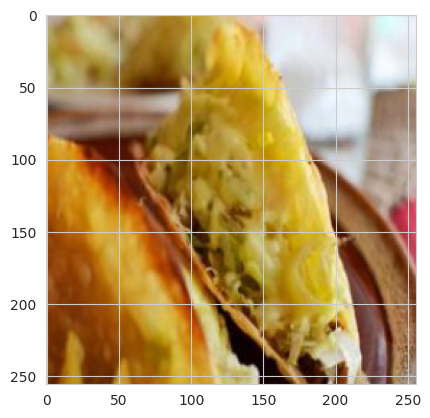

(15, 256, 256, 3)


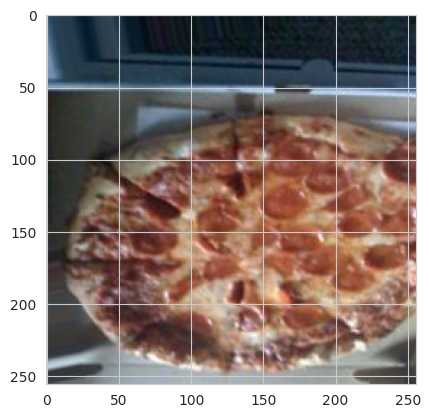

(15, 256, 256, 3)


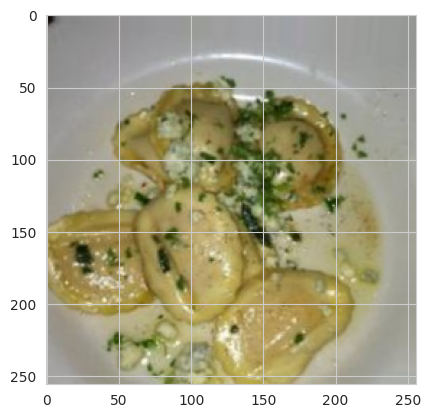

In [32]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

## Plot augmented validation and test images

(15, 256, 256, 3)


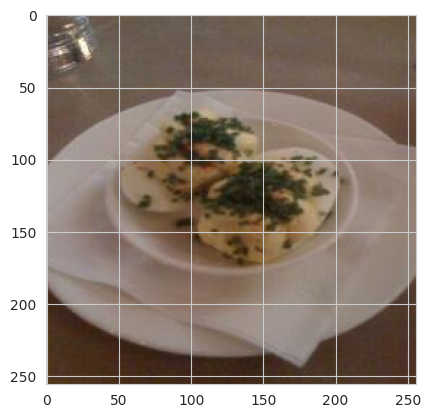

(15, 256, 256, 3)


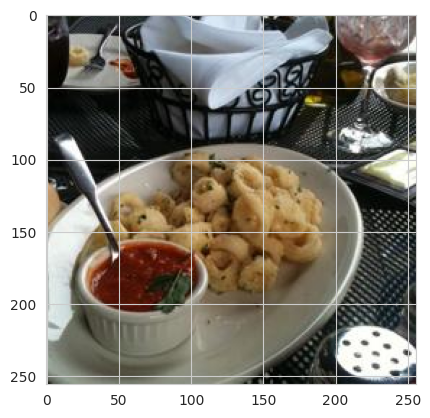

(15, 256, 256, 3)


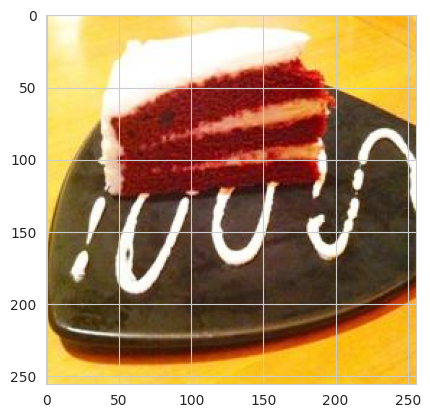

In [33]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

(15, 256, 256, 3)


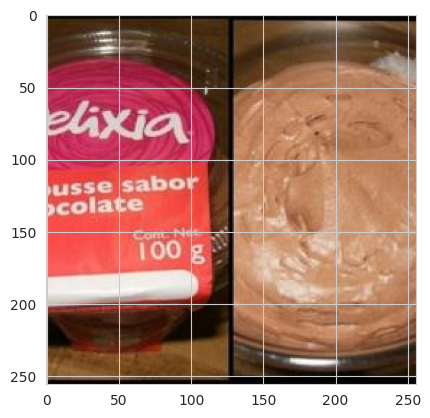

(15, 256, 256, 3)


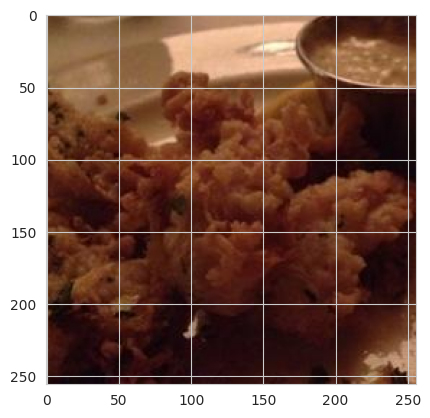

(15, 256, 256, 3)


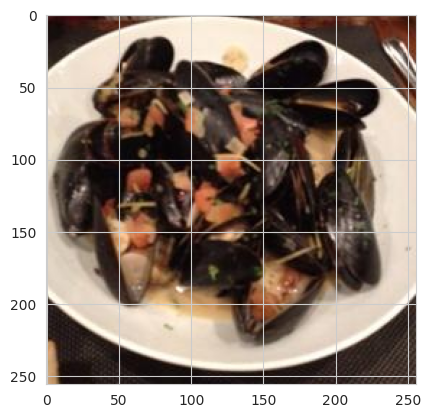

In [34]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

## Save class_indices

In [35]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

---

# Model creation

---

In [36]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

In [37]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, Dense
from tensorflow.keras.regularizers import l2

# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=image_shape)

# Customize the top layers for your binary classification task
x = base_model.output
x = Flatten()(x)

# Add a Dense layer with L2 regularization
x = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x)

# Add a Dropout layer
x = Dropout(0.5)(x)

# Add another Dense layer with L2 regularization
x = Dense(16, activation='relu', kernel_regularizer=l2(0.01))(x)

predictions = Dense(1, activation='sigmoid')(x)

# Create a new model by combining the base model and custom top layers
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the pre-trained model (optional)
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with your data
model.fit(train_set, 
          epochs=10, 
          steps_per_epoch=len(train_set.classes) // batch_size, 
          validation_data=validation_set, 
          callbacks=[early_stop], 
          verbose=1)


# Load the pre-trained VGG16 model
#base_model = VGG16(weights='imagenet', include_top=False, input_shape=image_shape)

# Customize the top layers for your binary classification task
#x = base_model.output
#x = Flatten()(x)
#x = Dense(32, activation='relu')(x)
#x = Dense(16, activation='relu')(x)
#predictions = Dense(1, activation='sigmoid')(x)

# Create a new model by combining the base model and custom top layers
#model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the pre-trained model (optional)
#for layer in base_model.layers:
#    layer.trainable = False

# Compile the model
#model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with your data
#model.fit(train_set, 
#          epochs=5, 
#          steps_per_epoch=len(train_set.classes) // batch_size, 
#          validation_data=validation_set, 
#          callbacks=[early_stop], 
#          verbose=1)

Epoch 1/10
91/91 [==============================] - 593s 7s/step - loss: 1.0557 - accuracy: 0.5753 - val_loss: 0.8506 - val_accuracy: 0.7908
Epoch 2/10
91/91 [==============================] - 633s 7s/step - loss: 0.7611 - accuracy: 0.6334 - val_loss: 0.6904 - val_accuracy: 0.8316
Epoch 3/10
91/91 [==============================] - 607s 7s/step - loss: 0.6774 - accuracy: 0.6561 - val_loss: 0.5319 - val_accuracy: 0.8316
Epoch 4/10
91/91 [==============================] - 654s 7s/step - loss: 0.6618 - accuracy: 0.6517 - val_loss: 0.6160 - val_accuracy: 0.7653
Epoch 5/10
91/91 [==============================] - 596s 7s/step - loss: 0.6360 - accuracy: 0.6605 - val_loss: 0.5495 - val_accuracy: 0.8316
Epoch 6/10
91/91 [==============================] - 611s 7s/step - loss: 0.6017 - accuracy: 0.6723 - val_loss: 0.4920 - val_accuracy: 0.8367
Epoch 7/10
91/91 [==============================] - 626s 7s/step - loss: 0.6402 - accuracy: 0.6561 - val_loss: 0.5535 - val_accuracy: 0.8265
Epoch 8/10
91

In [40]:
# Add model summary
model.save('outputs/v1/pizza_detector_model.h5')

---

## ML model

* ### Import model packages

In [22]:
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

* ### Model 

In [23]:
#def create_tf_model():
#    model = Sequential()

#    model.add(Conv2D(filters=32, kernel_size=(3, 3),
#              input_shape=image_shape, activation='relu', ))
#    model.add(MaxPooling2D(pool_size=(2, 2)))

#    model.add(Conv2D(filters=64, kernel_size=(3, 3),
#              input_shape=image_shape, activation='relu', ))
#    model.add(MaxPooling2D(pool_size=(2, 2)))

#    model.add(Conv2D(filters=64, kernel_size=(3, 3),
#              input_shape=image_shape, activation='relu', ))
#    model.add(MaxPooling2D(pool_size=(2, 2)))

#    model.add(Flatten())
#    model.add(Dense(128, activation='relu'))

#    model.add(Dropout(0.5))
#    model.add(Dense(1, activation='sigmoid'))

#    model.compile(loss='binary_crossentropy',
#                  optimizer='adam',
#                  metrics=['accuracy'])

#    return model

* ### Model Summary 

In [24]:
#create_tf_model().summary()

2023-10-29 12:19:58.062804: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0

* ### Early Stopping 

## Fit model for model training

In [25]:
#model = create_tf_model()
#model.fit(train_set,
#          epochs=10,
#          steps_per_epoch=len(train_set.classes) // batch_size,
#          validation_data=validation_set,
#          callbacks=[early_stop],
#          verbose=1
#          )

2023-10-29 12:20:05.159727: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
55/55 [==============================] - 123s 2s/step - loss: 0.7081 - accuracy: 0.5537 - val_loss: 0.6658 - val_accuracy: 0.5918
Epoch 2/10
55/55 [==============================] - 113s 2s/step - loss: 0.6662 - accuracy: 0.6144 - val_loss: 0.6329 - val_accuracy: 0.6378
Epoch 3/10
55/55 [==============================] - 117s 2s/step - loss: 0.6153 - accuracy: 0.6691 - val_loss: 0.5433 - val_accuracy: 0.7245
Epoch 4/10
55/55 [==============================] - 115s 2s/step - loss: 0.6023 - accuracy: 0.6758 - val_loss: 0.5308 - val_accuracy: 0.6939
Epoch 5/10
55/55 [==============================] - 115s 2s/step - loss: 0.5755 - accuracy: 0.7150 - val_loss: 0.5247 - val_accuracy: 0.7347
Epoch 6/10
55/55 [==============================] - 114s 2s/step - loss: 0.5501 - accuracy: 0.7313 - val_loss: 0.5138 - val_accuracy: 0.7449
Epoch 7/10
55/55 [==============================] - 113s 2s/step - loss: 0.5573 - accuracy: 0.7246 - val_loss: 0.4932 - val_accuracy: 0.7551
Epoch 8/10
55

## Save model

In [ ]:
#model.save('outputs/v1/pizza_detector_model.h5')

---

# Model Performace

---

## Model learning curve

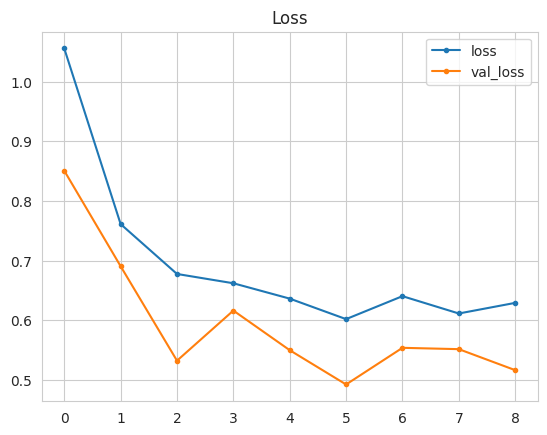

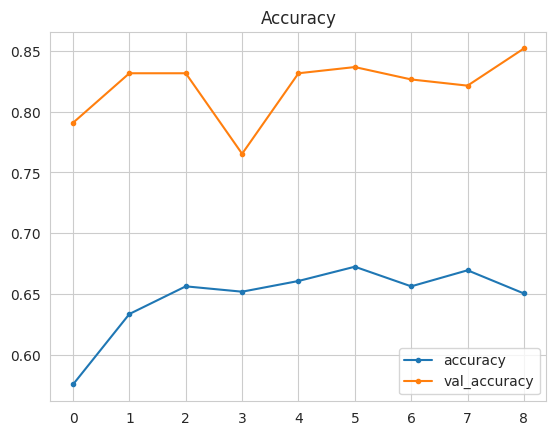

In [38]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

## Model Evaluation

Load saved model:

In [43]:
from keras.models import load_model
model = load_model('outputs/v1/pizza_detector_model.h5')

Evaluate model on test set:

In [44]:
evaluation = model.evaluate(test_set)

27/27 [==============================] - 148s 5s/step - loss: 0.4965 - accuracy: 0.8553


### Save evaluation pickle

In [45]:
joblib.dump(value=evaluation,
            filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

## Predict on new data

Load a random image as PIL:

Image shape: (256, 256), Image mode: RGB


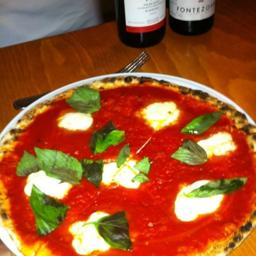

In [46]:
from tensorflow.keras.preprocessing import image

pointer = 66
label = labels[0]  # select Uninfected or Parasitised

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

Convert image to array and prepare for prediction:

In [47]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 256, 256, 3)


Predict class probabilities:

In [48]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]

if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)

0.6676556
pizza


---

# Push files to Repo

* .gitignore

In [34]:
#!cat .gitignore

* Git status

In [35]:
#!git status

* Git add

In [36]:
#!git add .

* Git commit

In [37]:
#!git commit -am " Add new plots"

* Git Push

In [38]:
#!git push